In [480]:
import torch
from collections import deque
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt
import pandas as pd

plt.style.use('classic')

from plot_tools import *

In [481]:
def path_len_fn(path):
    path = path.strip('][').split(', ')
    return len(path)

def path_sum_fn(a):
    a = a.strip('][').split(', ')
    a = list(map(int,a))
    return sum(a)

In [482]:
results_dfs = []
run_ids = np.arange(1,11)
lawn_num = 31
go_explore = False
reward_function = 2
run_max = 1e10

for run_id in run_ids:
    csv_path = f"../PPO_logs/lawn{lawn_num}/go_explore_{go_explore}/reward_function{reward_function}/{run_id}.csv"
    reward_data = pd.read_csv(csv_path, index_col = 'Run')
    reward_data['rewards_100'] = reward_data['Score'].rolling(100).mean()
    reward_data['rewards_100_max'] = reward_data['Score'].rolling(100).max()
    reward_data['perc_done_100'] = reward_data['Perc_done'].rolling(100).mean()
    reward_data['perc_done_100_max'] = reward_data['Perc_done'].rolling(100).max()
    reward_data['Length'] = reward_data['Path'].apply(path_len_fn)
    reward_data['Cum_Len'] = reward_data['Length'].cumsum()
    reward_data['Running_Min'] = reward_data['Frames'].cummin()
    reward_data['rolling_100_min'] = reward_data['Frames'].rolling(100).min()
    reward_data.dropna(inplace = True)
    results_dfs.append(reward_data)

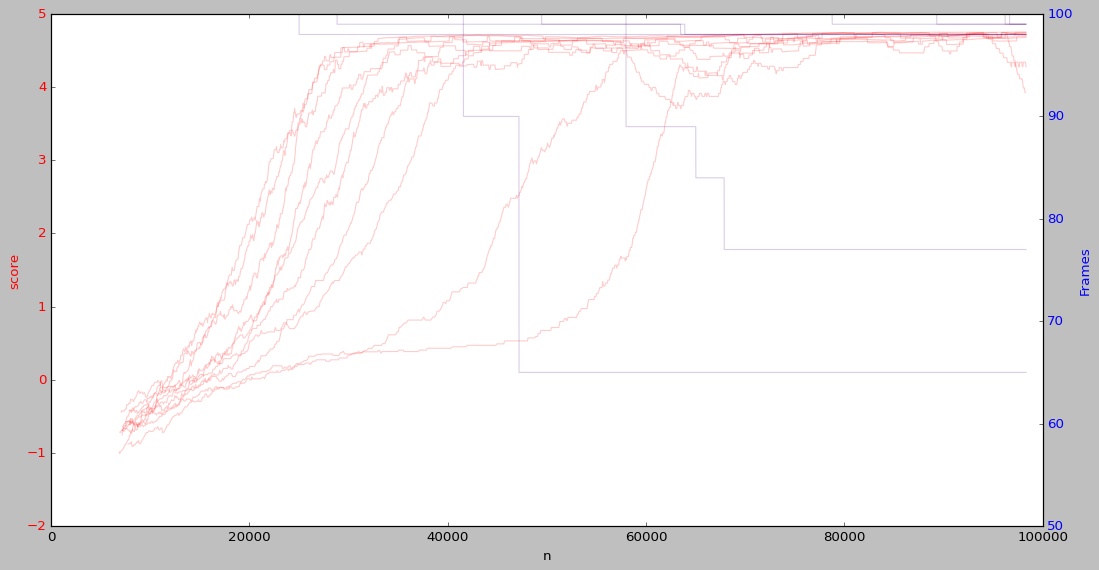

In [483]:
fig, ax = plt.subplots(1, 1, sharex=True, sharey=False, figsize=(16, 8))#, figsize=(10, 4))

ax.set_ylabel('score', color='red')
ax.tick_params(axis='y', labelcolor='red')
ax.set_xlabel('n', color = 'black')

ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('Frames', color='blue')  # we already handled the x-label with ax1
ax2.tick_params(axis='y', labelcolor='blue')

ax2.set_ylim(50,100)

for reward_data in results_dfs:


    ax.plot(reward_data['Cum_Len'], reward_data['rewards_100'], color='red', label = 'Score', alpha = 0.2)
    #ax.plot(reward_data['Cum_Len'], reward_data['rewards_100_max'], color='orange', label = 'Score', alpha = 0.2)




    color = 'blue'

    ax2.plot(reward_data['Cum_Len'], reward_data['Running_Min'], color='indigo', alpha = 0.2)
    #ax2.plot(reward_data['Cum_Len'], reward_data['rolling_100_min'], color='indigo', alpha = 0.2)





# Tables for Lawn 11, 12


In [484]:
f_go = np.array([15,30,45,15,30,45,15,30,45])

n_pcs = np.array([2,2,2,4,4,4,6,6,6])

num_go = 2*n_pcs / f_go
num_det = 1 / f_go
num_not = (f_go - 2*n_pcs - 1) / f_go

pd.DataFrame({
    'f_go': f_go,
    'n_pcs': n_pcs,
    'num_go': num_go,
    'num_det': num_det,
    'num_not': num_not
})





,f_go,n_pcs,num_go,num_det,num_not
0,15,2,0.266667,0.066667,0.666667
1,30,2,0.133333,0.033333,0.833333
2,45,2,0.088889,0.022222,0.888889
3,15,4,0.533333,0.066667,0.400000
4,30,4,0.266667,0.033333,0.700000
5,45,4,0.177778,0.022222,0.800000
6,15,6,0.800000,0.066667,0.133333
7,30,6,0.400000,0.033333,0.566667
8,45,6,0.266667,0.022222,0.711111


In [485]:
done_idxs = []
frame_min_idxs = []
frame_mins = []

score_max_idxs = []
score_maxs = []

results_dfs = []
outliers = []
outlier_offset = 0
run_ids = np.arange(1,11)
lawn_num = 31
go_explore = False
reward_function = 2
run_max = 1e10

outlier_offset = 0

for run_id in run_ids:
    csv_path = f"../PPO_logs/lawn{lawn_num}/go_explore_{go_explore}/reward_function{reward_function}/{run_id}.csv"
    reward_data = pd.read_csv(csv_path, index_col = 'Run')
    reward_data['Length'] = reward_data['Path'].apply(path_len_fn) - reward_data['Go_Explore_Copied'].apply(path_sum_fn)
    reward_data['Cum_Len'] = reward_data['Length'].cumsum()

    reward_data = reward_data.set_index('Cum_Len')
    done_idx = reward_data['Perc_done'].idxmax()
    temp = reward_data[reward_data['Perc_done'] >= 100]
    try:
        frame_min_idx = temp['Frames'].idxmin()
        frame_min = temp['Frames'][frame_min_idx]
        outlier = np.nan
    except:
        done_idx = 1e10
        frame_min_idx = 1e10
        frame_min = 1e10
        outlier = 1e11 + outlier_offset
        outlier_offset += 1000

    score_max_idx = reward_data['Score'].idxmax()
    score_max = reward_data['Score'][score_max_idx]

    results_dfs.append(reward_data)
    done_idxs.append(done_idx)
    frame_min_idxs.append(frame_min_idx)
    frame_mins.append(frame_min)
    outliers.append(outlier)

    score_max_idxs.append(score_max_idx)
    score_maxs.append(score_max)


In [486]:
table_df = pd.DataFrame(
    {'First Done': done_idxs,
     'Fastest Run': frame_mins,
     'Index': frame_min_idxs,
     'Scores': score_maxs,
     'Outlier': outliers
    }
)
table_df.index = np.arange(1,11)

In [487]:
print(
    table_df.to_latex()
)

\begin{tabular}{lrrrrr}
\toprule
{} &  First Done &  Fastest Run &  Index &    Scores &  Outlier \\
\midrule
1  &         804 &           98 &  25025 &  4.762184 &      NaN \\
2  &        5531 &           98 &  63913 &  4.762184 &      NaN \\
3  &         751 &          110 &  88790 &  4.734040 &      NaN \\
4  &         748 &           77 &  67882 &  4.836061 &      NaN \\
5  &         405 &           99 &  78769 &  4.759545 &      NaN \\
6  &        4007 &           99 &  96657 &  4.759545 &      NaN \\
7  &        1451 &           98 &  63485 &  4.762184 &      NaN \\
8  &        1663 &           65 &  47194 &  4.904074 &      NaN \\
9  &         503 &           99 &  89310 &  4.759545 &      NaN \\
10 &        1048 &           99 &  96202 &  4.759545 &      NaN \\
\bottomrule
\end{tabular}



C:\Users\jrisk\AppData\Local\Temp\ipykernel_34340\1343809659.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  table_df.to_latex()


In [488]:

def IQR(dist):
    return np.percentile(dist, 75) - np.percentile(dist, 25)

In [489]:
lawn_num = 31
go_explore = True
reward_function = 2

f_gos = []
n_pcs = []
done_idxs_res = []
score_max_idxs_res = []
frame_min_res = []
done_idxs_res_sd = []
score_max_idxs_res_sd = []
frame_min_res_sd = []



In [490]:
done_idxs = []
frame_min_idxs = []
frame_mins = []
outliers = []
outlier_offset = 0

score_max_idxs = []
score_maxs = []

f_go = 0
n_pc = 0
j = 1
go_explore = False
for i in np.arange(1,11):
    run_id = j
    csv_path = f"../PPO_logs/lawn{lawn_num}/go_explore_{go_explore}/reward_function{reward_function}/{run_id}.csv"
    reward_data = pd.read_csv(csv_path, index_col = 'Run')
    reward_data['Length'] = reward_data['Path'].apply(path_len_fn) - reward_data['Go_Explore_Copied'].apply(path_sum_fn)
    reward_data['Cum_Len'] = reward_data['Length'].cumsum()

    reward_data = reward_data.set_index('Cum_Len')
    done_idx = reward_data['Perc_done'].idxmax()
    temp = reward_data[reward_data['Perc_done'] >= 100]
    try:
        frame_min_idx = temp['Frames'].idxmin()
        frame_min = temp['Frames'][frame_min_idx]
        outlier = np.nan
    except:
        done_idx = 1e10
        frame_min_idx = 1e10
        frame_min = 1e10
        outlier = 1e11 + outlier_offset
        outlier_offset += 1000

    score_max_idx = reward_data['Score'].idxmax()
    score_max = reward_data['Score'][score_max_idx]

    done_idxs.append(done_idx)
    frame_min_idxs.append(frame_min_idx)
    frame_mins.append(frame_min)
    outliers.append(outlier)

    score_max_idxs.append(score_max_idx)
    score_maxs.append(score_max)
    j += 1
n_pcs.append(n_pc)
f_gos.append(f_go)

done_idxs_res.append(np.mean(np.array(done_idxs)))
score_max_idxs_res.append(np.mean(np.array(score_max_idxs)))
frame_min_res.append(np.mean(np.array(frame_mins)))
done_idxs_res_sd.append(np.std(np.array(done_idxs)))
score_max_idxs_res_sd.append(np.std(np.array(score_max_idxs)))
frame_min_res_sd.append(np.std(np.array(frame_mins)))

In [491]:
j = 101
go_explore = False
for i in np.arange(1,11):
    run_id = j
    csv_path = f"../PPO_logs/lawn{lawn_num}/go_explore_{go_explore}/reward_function{reward_function}/{run_id}.csv"
    reward_data = pd.read_csv(csv_path, index_col = 'Run')
    reward_data['Length'] = reward_data['Path'].apply(path_len_fn) - reward_data['Go_Explore_Copied'].apply(path_sum_fn)
    reward_data['Cum_Len'] = reward_data['Length'].cumsum()

    reward_data = reward_data.set_index('Cum_Len')
    done_idx = reward_data['Perc_done'].idxmax()
    temp = reward_data[reward_data['Perc_done'] >= 100]
    try:
        frame_min_idx = temp['Frames'].idxmin()
        frame_min = temp['Frames'][frame_min_idx]
        outlier = np.nan
    except:
        done_idx = 1e10
        frame_min_idx = 1e10
        frame_min = 1e10
        outlier = 1e11 + outlier_offset
        outlier_offset += 1000

    score_max_idx = reward_data['Score'].idxmax()
    score_max = reward_data['Score'][score_max_idx]

    done_idxs.append(done_idx)
    frame_min_idxs.append(frame_min_idx)
    frame_mins.append(frame_min)
    outliers.append(outlier)

    score_max_idxs.append(score_max_idx)
    score_maxs.append(score_max)
    j += 1
n_pcs.append(n_pc)
f_gos.append(f_go)

done_idxs_res.append(np.mean(np.array(done_idxs)))
score_max_idxs_res.append(np.mean(np.array(score_max_idxs)))
frame_min_res.append(np.mean(np.array(frame_mins)))
done_idxs_res_sd.append(np.std(np.array(done_idxs)))
score_max_idxs_res_sd.append(np.std(np.array(score_max_idxs)))
frame_min_res_sd.append(np.std(np.array(frame_mins)))


In [492]:
plt_df = pd.DataFrame({
    'n_pc': 0,
    'f_go': 0,
    'frame_min': frame_mins,
    'done_idx': done_idxs,
    'outlier': outliers
})

In [493]:
plt_df

,n_pc,f_go,frame_min,done_idx,outlier
0,0,0,98,804,NaN
1,0,0,98,5531,NaN
2,0,0,110,751,NaN
3,0,0,77,748,NaN
4,0,0,99,405,NaN
5,0,0,99,4007,NaN
6,0,0,98,1451,NaN
7,0,0,65,1663,NaN
8,0,0,99,503,NaN
9,0,0,99,1048,NaN


In [494]:
go_explore = True

j = 11
for n_pc in [2,4,6]:
    for f_go in [15,30,45]:
        done_idxs = []
        frame_min_idxs = []
        frame_mins = []
        outliers = []
        outlier_offset = 0

        score_max_idxs = []
        score_maxs = []
        for i in np.arange(1,11):
            run_id = j
            csv_path = f"../PPO_logs/lawn{lawn_num}/go_explore_{go_explore}/reward_function{reward_function}/{run_id}.csv"
            reward_data = pd.read_csv(csv_path, index_col = 'Run')
            reward_data['Length'] = reward_data['Path'].apply(path_len_fn) - reward_data['Go_Explore_Copied'].apply(path_sum_fn)
            reward_data['Cum_Len'] = reward_data['Length'].cumsum()

            reward_data = reward_data.set_index('Cum_Len')
            done_idx = reward_data['Perc_done'].idxmax()
            temp = reward_data[reward_data['Perc_done'] >= 100]
            try:
                frame_min_idx = temp['Frames'].idxmin()
                frame_min = temp['Frames'][frame_min_idx]
                outlier = np.nan
            except:
                done_idx = 1e10
                frame_min_idx = 1e10
                frame_min = 1e10
                outlier = 1e11 + outlier_offset
                outlier_offset += 1000
            score_max_idx = reward_data['Score'].idxmax()
            score_max = reward_data['Score'][score_max_idx]

            done_idxs.append(done_idx)
            frame_min_idxs.append(frame_min_idx)
            frame_mins.append(frame_min)
            outliers.append(outlier)

            score_max_idxs.append(score_max_idx)
            score_maxs.append(score_max)
            j += 1
        n_pcs.append(n_pc)
        f_gos.append(f_go)

        # done_idxs_res.append(np.median(np.array(done_idxs)))
        # score_max_idxs_res.append(np.median(np.array(score_max_idxs)))
        # frame_min_res.append(np.median(np.array(frame_mins)))
        # done_idxs_res_sd.append(IQR(np.array(done_idxs)))
        # score_max_idxs_res_sd.append(IQR(np.array(score_max_idxs)))
        # frame_min_res_sd.append(IQR(np.array(frame_mins)))
        done_idxs_res.append(np.mean(np.array(done_idxs)))
        score_max_idxs_res.append(np.mean(np.array(score_max_idxs)))
        frame_min_res.append(np.mean(np.array(frame_mins)))
        done_idxs_res_sd.append(np.std(np.array(done_idxs)))
        score_max_idxs_res_sd.append(np.std(np.array(score_max_idxs)))
        frame_min_res_sd.append(np.std(np.array(frame_mins)))

        plt_temp = pd.DataFrame({
            'n_pc': n_pc,
            'f_go': f_go,
            'frame_min': frame_mins,
            'done_idx': done_idxs,
            'outlier': outliers
        })

        plt_df = pd.concat([plt_df, plt_temp])



j = 111
for n_pc in [2,4,6]:
    for f_go in [15,30,45]:
        done_idxs = []
        frame_min_idxs = []
        frame_mins = []
        outliers = []
        outlier_offset = 0

        score_max_idxs = []
        score_maxs = []
        for i in np.arange(1,11):
            run_id = j
            csv_path = f"../PPO_logs/lawn{lawn_num}/go_explore_{go_explore}/reward_function{reward_function}/{run_id}.csv"
            reward_data = pd.read_csv(csv_path, index_col = 'Run')
            reward_data['Length'] = reward_data['Path'].apply(path_len_fn) - reward_data['Go_Explore_Copied'].apply(path_sum_fn)
            reward_data['Cum_Len'] = reward_data['Length'].cumsum()

            reward_data = reward_data.set_index('Cum_Len')
            done_idx = reward_data['Perc_done'].idxmax()
            temp = reward_data[reward_data['Perc_done'] >= 100]
            try:
                frame_min_idx = temp['Frames'].idxmin()
                frame_min = temp['Frames'][frame_min_idx]
                outlier = np.nan
            except:
                done_idx = 1e10
                frame_min_idx = 1e10
                frame_min = 1e10
                outlier = 1e11 + outlier_offset
                outlier_offset += 1000
            score_max_idx = reward_data['Score'].idxmax()
            score_max = reward_data['Score'][score_max_idx]

            done_idxs.append(done_idx)
            frame_min_idxs.append(frame_min_idx)
            frame_mins.append(frame_min)
            outliers.append(outlier)

            score_max_idxs.append(score_max_idx)
            score_maxs.append(score_max)
            j += 1
        n_pcs.append(n_pc)
        f_gos.append(f_go)

        # done_idxs_res.append(np.median(np.array(done_idxs)))
        # score_max_idxs_res.append(np.median(np.array(score_max_idxs)))
        # frame_min_res.append(np.median(np.array(frame_mins)))
        # done_idxs_res_sd.append(IQR(np.array(done_idxs)))
        # score_max_idxs_res_sd.append(IQR(np.array(score_max_idxs)))
        # frame_min_res_sd.append(IQR(np.array(frame_mins)))
        done_idxs_res.append(np.mean(np.array(done_idxs)))
        score_max_idxs_res.append(np.mean(np.array(score_max_idxs)))
        frame_min_res.append(np.mean(np.array(frame_mins)))
        done_idxs_res_sd.append(np.std(np.array(done_idxs)))
        score_max_idxs_res_sd.append(np.std(np.array(score_max_idxs)))
        frame_min_res_sd.append(np.std(np.array(frame_mins)))

        plt_temp = pd.DataFrame({
            'n_pc': n_pc,
            'f_go': f_go,
            'frame_min': frame_mins,
            'done_idx': done_idxs,
            'outlier': outliers
        })

        plt_df = pd.concat([plt_df, plt_temp])

In [495]:
pd.set_option('display.max_rows', 200)
plt_df

,n_pc,f_go,frame_min,done_idx,outlier
0,0,0,98,804,NaN
1,0,0,98,5531,NaN
2,0,0,110,751,NaN
3,0,0,77,748,NaN
4,0,0,99,405,NaN
5,0,0,99,4007,NaN
6,0,0,98,1451,NaN
7,0,0,65,1663,NaN
8,0,0,99,503,NaN
9,0,0,99,1048,NaN


In [496]:
done_min, done_max = plt_df['done_idx'].min(), plt_df['done_idx'].max()
frame_min, frame_max = plt_df['frame_min'].min(), plt_df['frame_min'].max()


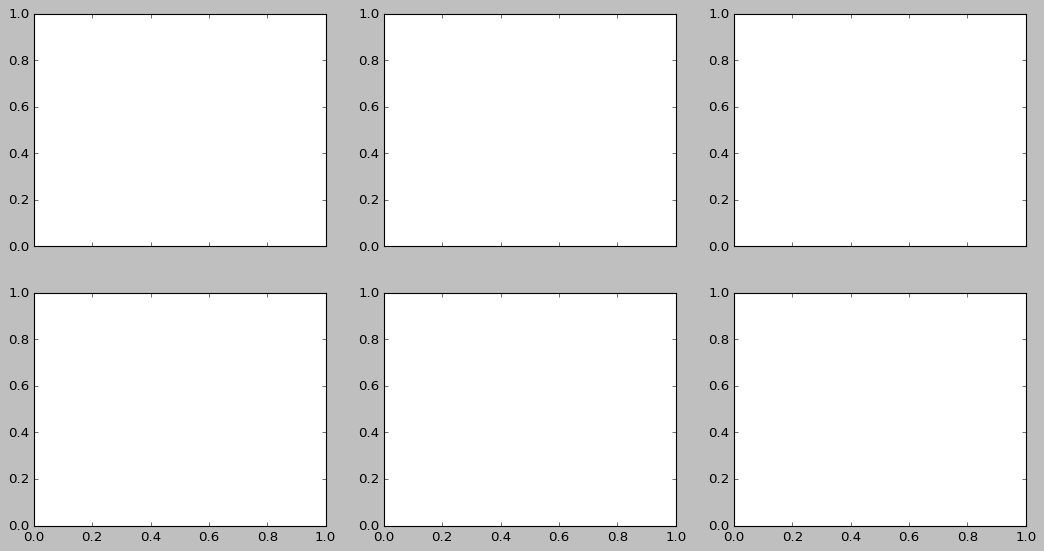

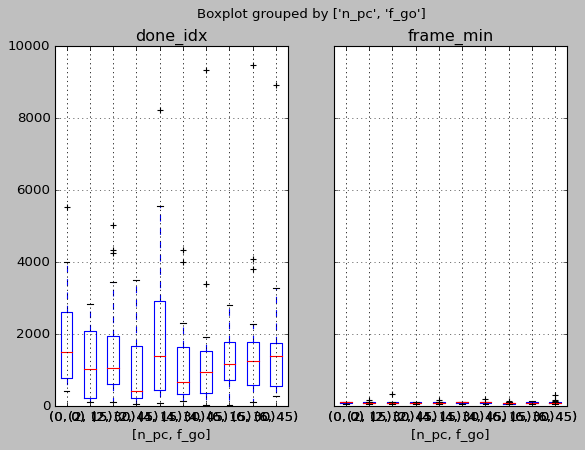

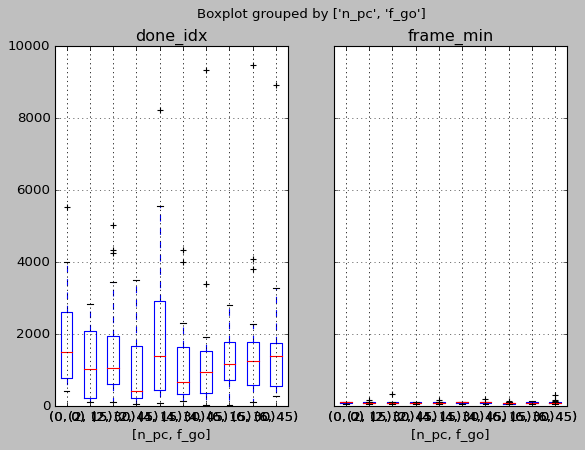

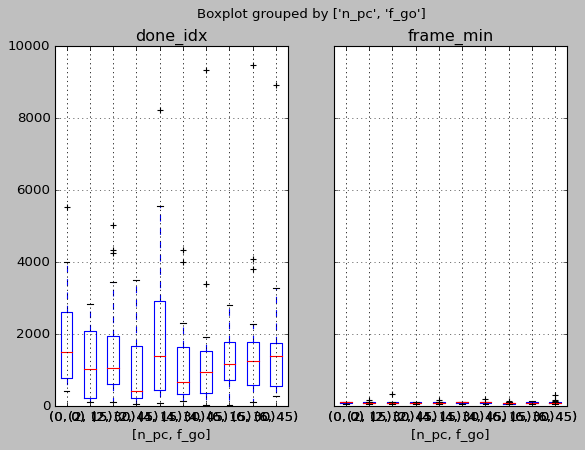

In [497]:
fig, axs = plt.subplots(2, 3, sharex=True, sharey=False, figsize=(16, 8))


j_plt = 0

for f_go in [15,30,45]:
    #plt_temp = plt_df[plt_df['f_go'] == f_go]
    #axs[0,j_plt].plot(plt_temp['n_pc'], plt_temp['done_idx'], "co", ms = 5, linestyle = '')
    #axs[1,j_plt].plot(plt_temp['n_pc'], plt_temp['frame_min'], "ro", ms = 5, linestyle = '')

    #axs[0,j_plt].set_ylim(done_min, done_max)
    #axs[1,j_plt].set_ylim(frame_min, frame_max)

    plt_df.boxplot(column = ['done_idx', 'frame_min'],
                   by = ['n_pc', 'f_go'])

    j_plt += 1



In [498]:
pd.set_option('display.max_rows', 100)
plt_df

,n_pc,f_go,frame_min,done_idx,outlier
0,0,0,98,804,NaN
1,0,0,98,5531,NaN
2,0,0,110,751,NaN
3,0,0,77,748,NaN
4,0,0,99,405,NaN
...,...,...,...,...,...
5,6,45,98,3289,NaN
6,6,45,64,2633,NaN
7,6,45,98,8908,NaN
8,6,45,77,854,NaN


([<matplotlib.axis.YTick at 0x2b409eb2bb0>,
 [Text(0, 0, '0'),
  Text(0, 20000, '20000'),
  Text(0, 40000, '40000'),
  Text(0, 60000, '60000'),
  Text(0, 80000, '80000'),
  Text(0, 100000, '100000'),
  Text(0, 115000, 'NA')])

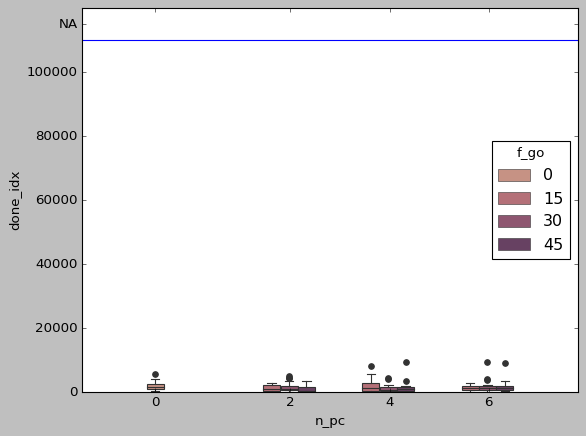

In [499]:
import seaborn as sns

ax = sns.boxplot(data = plt_df, y = 'done_idx',
            x = 'n_pc', hue = 'f_go',
            fliersize = 5,
            saturation = 0.5,
            flierprops={"marker": "o"},
            width = 0.7,
            palette = 'flare')

y_max = 120000
y_max_ = 110000

plt_df['outlier_x'] = plt_df['n_pc']/2 + (plt_df['f_go']) * 0.01333 -0.3


outlier_max = np.max(plt_df['outlier'])
outlier_min = np.min(plt_df['outlier'])

plt_df['outlier'] = plt_df['outlier'] - outlier_min
plt_df['outlier'] = plt_df['outlier'] / (outlier_max - outlier_min) * (y_max * 0.99 - y_max_ * 1.01) + y_max_ * 1.01





ax.scatter(plt_df['outlier_x'], plt_df['outlier'], s = 100, c='r', marker = '_')

ax.set_ylim(0,y_max)
ax.set_xlim(-1,4)

ax.plot((-10,10),(y_max_,y_max_))

x = [0,2,4,6]
default_x_ticks = [-0.265,1.1,2.1,3.1]
plt.xticks(default_x_ticks, x)

y = [0,20000,40000,60000,80000,100000,'NA']
default_y_ticks = [0,20000,40000,60000,80000,100000,115000]
plt.yticks(default_y_ticks, y)


In [500]:
plt_df.sort_values('done_idx')

,n_pc,f_go,frame_min,done_idx,outlier,outlier_x
3,6,15,112,32,NaN,2.89995
3,4,45,83,34,NaN,2.29985
8,2,45,64,55,NaN,1.29985
8,6,15,64,81,NaN,2.89995
0,2,45,99,86,NaN,1.29985
...,...,...,...,...,...,...
4,4,15,173,5547,NaN,1.89995
2,4,15,98,8231,NaN,1.89995
7,6,45,98,8908,NaN,3.29985
8,4,45,98,9330,NaN,2.29985


([<matplotlib.axis.YTick at 0x2b40a017e50>,
 [Text(0, 0.0, '0'),
  Text(0, 200.0, '200'),
  Text(0, 400.0, '400'),
  Text(0, 600.0, '600'),
  Text(0, 800.0, '800'),
  Text(0, 950.0, 'NA')])

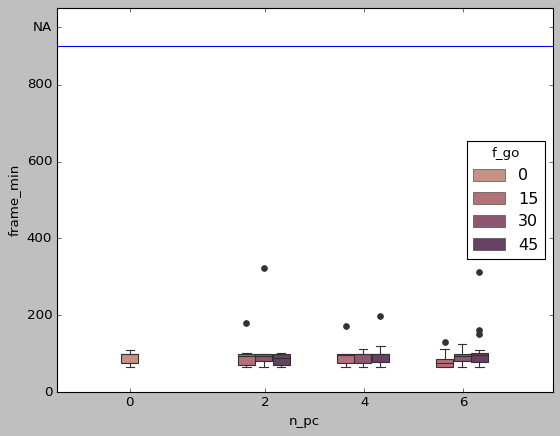

In [501]:
y_max = 1000
y_max_ = 900

ax = sns.boxplot(data = plt_df, y = 'frame_min',
            x = 'n_pc', hue = 'f_go',
            fliersize = 5,
            saturation = 0.5,
            flierprops={"marker": "o"},
            width = 0.7,
            palette = 'flare')

ax.set_ylim(100,y_max)



plt_df['outlier_x'] = plt_df['n_pc']/2 + (plt_df['f_go']) * 0.01333 -0.3

outlier_max = np.max(plt_df['outlier'])
outlier_min = np.min(plt_df['outlier'])

plt_df['outlier'] = plt_df['outlier'] - outlier_min
plt_df['outlier'] = plt_df['outlier'] / (outlier_max - outlier_min) * (y_max * 0.99 - y_max_ * 1.01) + y_max_ * 1.01




ax.scatter(plt_df['outlier_x'], plt_df['outlier'], s = 100, c='r', marker = '_')

ax.set_ylim(0,y_max)
ax.set_xlim(-1,4)

ax.plot((-10,10),(y_max_,y_max_))

x = [0,2,4,6]
default_x_ticks = [-0.265,1.1,2.1,3.1]
plt.xticks(default_x_ticks, x)

base_ticks = [0,200,400,600,800]
y = [0,200,400,600,800,'NA']
default_y_ticks = [0,200,400,600,800,(y_max + y_max_) / 2]
plt.yticks(default_y_ticks, y)


In [502]:
pd.set_option('display.max_rows', 200)
plt_df


,n_pc,f_go,frame_min,done_idx,outlier,outlier_x
0,0,0,98,804,NaN,-0.30000
1,0,0,98,5531,NaN,-0.30000
2,0,0,110,751,NaN,-0.30000
3,0,0,77,748,NaN,-0.30000
4,0,0,99,405,NaN,-0.30000
5,0,0,99,4007,NaN,-0.30000
6,0,0,98,1451,NaN,-0.30000
7,0,0,65,1663,NaN,-0.30000
8,0,0,99,503,NaN,-0.30000
9,0,0,99,1048,NaN,-0.30000


In [503]:
plt_df['frame_min'] == 1e10

0     False
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10    False
11    False
12    False
13    False
14    False
15    False
16    False
17    False
18    False
19    False
0     False
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
0     False
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
0     False
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
0     False
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
0     False
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
0     False
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
0     False
1     False
2     False
3   

In [504]:
plt_df['frame_min']




0      98
1      98
2     110
3      77
4      99
5      99
6      98
7      65
8      99
9      99
10     98
11     98
12     77
13     98
14     71
15     83
16     76
17     98
18     76
19     64
0     100
1      99
2      76
3      64
4      83
5     179
6      77
7      64
8      99
9      64
0      76
1      83
2      98
3      77
4      78
5      64
6      89
7      98
8      98
9      84
0      99
1      70
2      83
3      77
4      77
5      98
6      98
7      64
8      64
9      98
0      64
1      83
2      98
3      70
4     173
5      88
6      76
7      96
8      64
9      65
0      98
1      98
2      76
3      96
4      65
5      98
6     113
7     108
8      98
9     100
0      64
1     120
2      98
3      83
4      76
5      99
6      98
7     100
8      98
9      78
0      70
1      83
2     129
3      94
4     100
5      64
6      64
7      64
8      83
9      82
0      89
1      98
2      71
3     100
4      98
5      77
6      98
7      89
8      71
9      71








# Old Stuff


In [505]:

res_df = pd.DataFrame(
    {'f_go': f_gos,
     'n_pcs': n_pcs,
     'Done Index Mean': done_idxs_res,
     'Done Index sd': done_idxs_res_sd,
     'Score Max Index Mean': score_max_idxs_res,
     'Score Max Index sd': score_max_idxs_res_sd,
     'Frame Min Mean': frame_min_res,
     'Frame Min sd': frame_min_res_sd
    }
)


res_df

,f_go,n_pcs,Done Index Mean,Done Index sd,Score Max Index Mean,Score Max Index sd,Frame Min Mean,Frame Min sd
0,0,0,1691.10,1618.828184,71722.7,21902.388089,94.20,12.383860
1,0,0,1907.35,1327.632866,73775.6,21462.494649,89.05,13.406994
2,15,2,1205.50,913.250157,63522.8,15724.151594,90.50,32.592177
3,30,2,1628.40,1584.082839,65657.6,16006.761854,84.50,10.772651
4,45,2,433.10,403.442053,55220.5,22627.102135,82.80,13.760814
5,15,4,2315.80,2490.725388,84798.2,12859.067935,87.70,30.922645
6,30,4,824.10,759.334636,78282.0,10969.118798,95.00,13.475904
7,45,4,923.00,608.137813,58327.7,23101.619424,91.40,15.226293
8,15,6,1231.70,606.892256,67776.5,18665.815762,83.30,19.437335
9,30,6,1771.00,2608.512833,62741.5,17601.053703,86.20,11.838919


In [506]:
done_idxs






[1113, 301, 622, 1589, 1318, 3289, 2633, 8908, 854, 295]

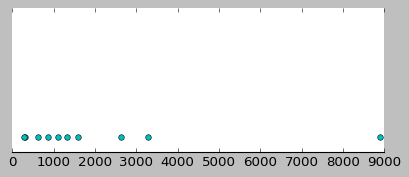

In [507]:

fig, ax = plt.subplots(figsize=(6, 2.25))

ax.plot(done_idxs, [-0.4]*len(done_idxs), "co", ms = 5, linestyle = '')

for spine in ['top', 'right', 'left']:
    ax.spines[spine].set_visible(False)
ax.yaxis.set_visible(False)
ax.set_ylim(-0.5, 0.5)
#ax.set_xticks(np.arange(min(done_idxs), max(done_idxs)+1,10))
#ax.set_xticks()
#ax.tick_params(axis='x', length=0, pad=8, labelsize=12)

plt.show()

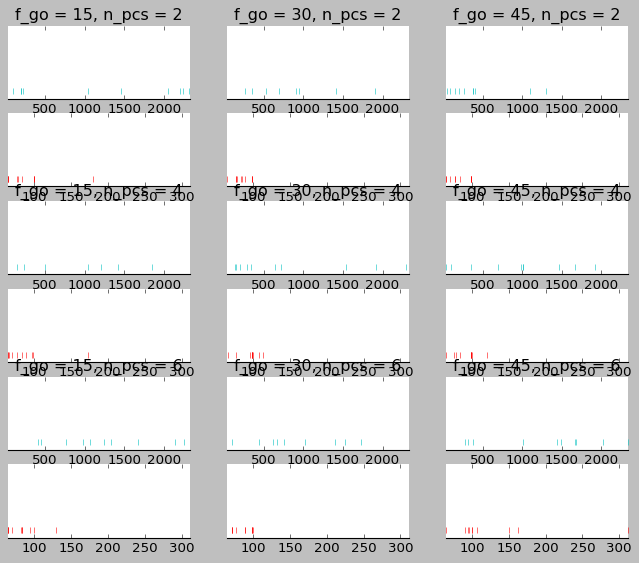

In [508]:
fig, axs = plt.subplots(6,3, figsize=(10, 8))

plt_i = 0
plt_j = 0

lawn_num = 31
go_explore = True
reward_function = 2

f_gos = []
n_pcs = []
done_idxs_res = []
score_max_idxs_res = []
frame_min_res = []
done_idxs_res_sd = []
score_max_idxs_res_sd = []
frame_min_res_sd = []

ax1min = 1e10
ax1max = 0
ax2min = 1e10
ax2max = 0

j = 11
for n_pc in [2,4,6]:
    for f_go in [15,30,45]:
        if plt_j == 3:
            plt_j = 0
            plt_i += 2
        done_idxs = []
        frame_min_idxs = []
        frame_mins = []

        score_max_idxs = []
        score_maxs = []
        for i in np.arange(1,11):
            run_id = j
            csv_path = f"../PPO_logs/lawn{lawn_num}/go_explore_{go_explore}/reward_function{reward_function}/{run_id}.csv"
            reward_data = pd.read_csv(csv_path, index_col = 'Run')
            reward_data['Length'] = reward_data['Path'].apply(path_len_fn) - reward_data['Go_Explore_Copied'].apply(path_sum_fn)
            reward_data['Cum_Len'] = reward_data['Length'].cumsum()

            reward_data = reward_data.set_index('Cum_Len')
            done_idx = reward_data['Perc_done'].idxmax()
            temp = reward_data[reward_data['Perc_done'] >= 100]
            frame_min_idx = temp['Frames'].idxmin()
            frame_min = temp['Frames'][frame_min_idx]

            score_max_idx = reward_data['Score'].idxmax()
            score_max = reward_data['Score'][score_max_idx]

            done_idxs.append(done_idx)
            frame_min_idxs.append(frame_min_idx)
            frame_mins.append(frame_min)

            score_max_idxs.append(score_max_idx)
            score_maxs.append(score_max)
            j += 1
        n_pcs.append(n_pc)
        f_gos.append(f_go)

        # done_idxs_res.append(np.median(np.array(done_idxs)))
        # score_max_idxs_res.append(np.median(np.array(score_max_idxs)))
        # frame_min_res.append(np.median(np.array(frame_mins)))
        # done_idxs_res_sd.append(IQR(np.array(done_idxs)))
        # score_max_idxs_res_sd.append(IQR(np.array(score_max_idxs)))
        # frame_min_res_sd.append(IQR(np.array(frame_mins)))
        done_idxs_res.append(np.mean(np.array(done_idxs)))
        score_max_idxs_res.append(np.mean(np.array(score_max_idxs)))
        frame_min_res.append(np.mean(np.array(frame_mins)))
        done_idxs_res_sd.append(np.std(np.array(done_idxs)))
        score_max_idxs_res_sd.append(np.std(np.array(score_max_idxs)))
        frame_min_res_sd.append(np.std(np.array(frame_mins)))

        ax1 = axs[plt_i, plt_j]
        ax2 = axs[plt_i+1, plt_j]

        ax1.plot(done_idxs, [-0.4]*len(done_idxs), "c|", ms = 5, linestyle = '')

        for spine in ['top', 'right', 'left']:
            ax1.spines[spine].set_visible(False)
        ax1.yaxis.set_visible(False)
        ax1.set_ylim(-0.5, 0.5)
        #ax.set_xticks(np.arange(min(done_idxs), max(done_idxs)+1,10))
        #ax.set_xticks()
        #ax.tick_params(axis='x', length=0, pad=8, labelsize=12)

        ax1.set_title(f'f_go = {f_go}, n_pcs = {n_pc}')

        ax2.plot(frame_mins, [-0.4]*len(frame_mins), "r|", ms = 5, linestyle = '')

        for spine in ['top', 'right', 'left']:
            ax2.spines[spine].set_visible(False)
        ax2.yaxis.set_visible(False)
        ax2.set_ylim(-0.5, 0.5)

        #ax1.sharex(axs[0,0])
        ax1min = min(ax1min,min(done_idxs))
        ax1max = max(ax1min,max(done_idxs))
        ax2min = min(ax2min,min(frame_mins))
        ax2max = max(ax2min,max(frame_mins))

        plt_j += 1

for a in [0,2,4]:
    for j in [0,1,2]:
        axs[a,j].set_xlim(ax1min,ax1max)
        axs[a+1,j].set_xlim(ax2min,ax2max)


In [509]:

axs[q,1:]

NameError: name 'q' is not defined